<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the first dataset

We first need to load the dataset. 

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (6,5)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
  Created wheel for flashtorch: filename=flashtorch-0.1.2-cp36-none-any.whl size=26236 sha256=bee145e56969070dbd6be8207f6b78ff88d45d65b6b4a1ec53918586392ace18
  Stored in directory: /root/.cache/pip/wheels/91/44/8e/c33cc10ab8d0f24036e82f0e475277dc4a479cd3fb03329a39
Successfully built flashtorch


Now, we need to redefine the model, so that we can compute a saliency map for an input image. Then, we also want to load the state_dict of the trained model. 

In [2]:
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 4)
    self.pool2 = nn.MaxPool2d(kernel_size = 5)
    self.fc1 = nn.Linear(in_features = 16*9*11, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.fc3 = nn.Linear(in_features = 84, out_features = 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model4.pth')) 

<All keys matched successfully>

Now, load and format the images we want to test the network's decision on. 

In [0]:
transforms = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

images = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data4", transform = transforms)

idx_to_class = {j:i for i,j in images.class_to_idx.items()}

Let's import an image with label 0. 

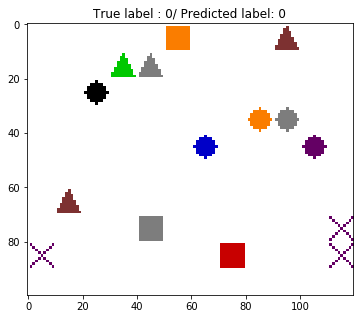

In [4]:
image0 = images[0][0]
label0 = images[0][1]

im0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 

outputs = net(im0)

_, predicted0 = torch.max(outputs.data, 1)

def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[true_label]
  
  if (predicted_label != None):
    title_ += "/ Predicted label: " + idx_to_class[predicted_label]


  plt.title(title_)


display_image(image0, label0, int(predicted0))

This image was correctly labeled as a 0, because it contains crosses (even though there is a black circle). 

What parts in the input were considered important by the network to make this call ? 

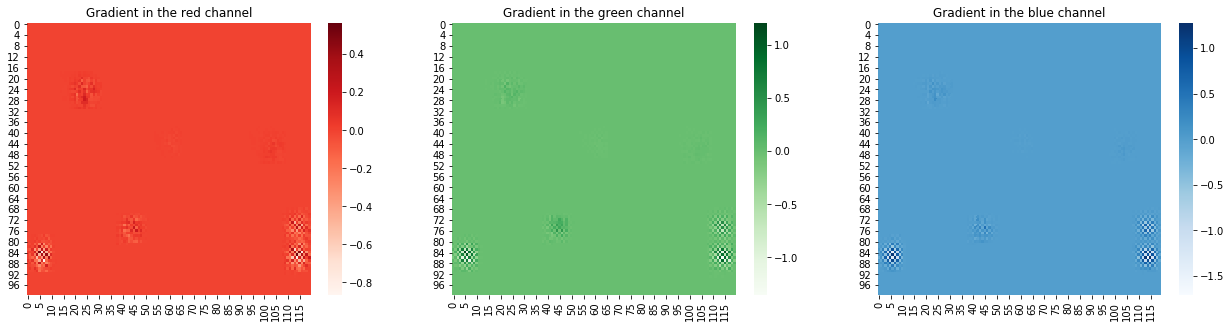

In [5]:
im0.requires_grad = True # Otherwise we can't compute the gradient 
backprop = Backprop(net)
gradients0 = backprop.calculate_gradients(im0, label0)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients0.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients0.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients0.detach().numpy()[2], cmap="Blues", ax = ax3)

Crosses and the black circle are most relevant, but the input region of the grey square also seems to matter. There is no color dependence, since black depends as much on the value of each channel. 

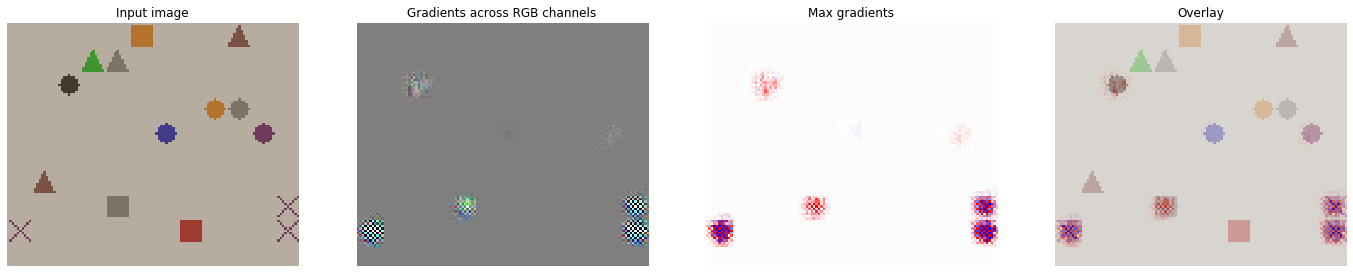

In [6]:
backprop.visualize(im0, label0, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

We observe the same thing here. 

What about an image with label 1 ?

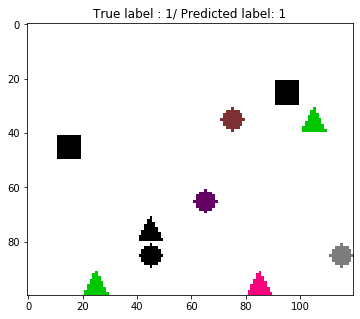

In [7]:
image1 = images[1][0]
label1 = images[1][1]

im1 = image1.view(-1, 3, 100, 120)
outputs = net(im1)
_, predicted1 = torch.max(outputs.data, 1)

display_image(image1, label1, int(predicted1))

This image was correctly labeled as a 1, because it contains a black circle but no crosses.

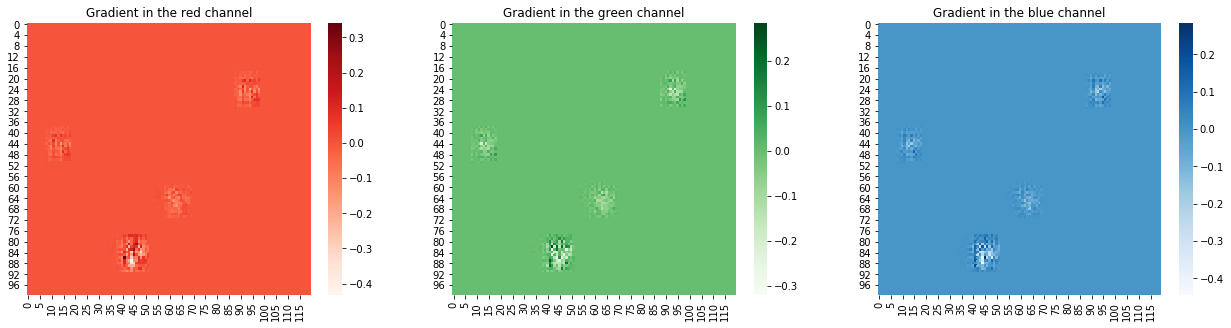

In [8]:
im1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(im1, label1)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients1.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients1.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients1.detach().numpy()[2], cmap="Blues", ax = ax3)

The region of the black circle is the most salient, but other black shapes or circles also are of importance for the classification. 

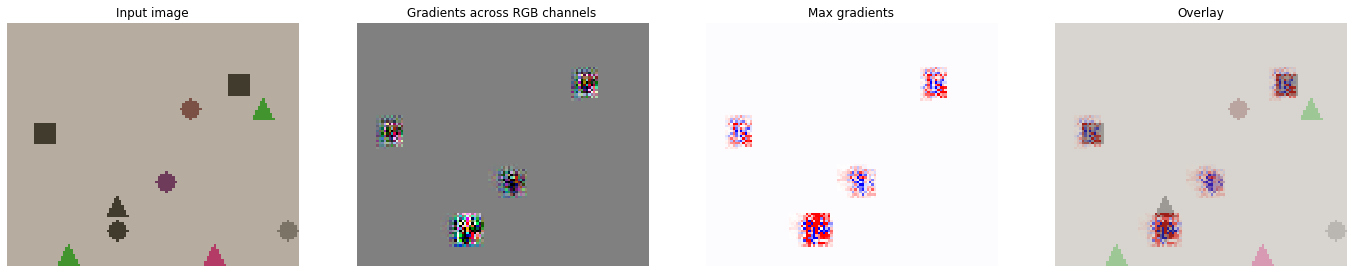

In [9]:
backprop.visualize(im1, label1, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap = 'bwr')

In [10]:
!pip install shap 
import shap
from torch.utils.data import DataLoader
import os 
import zipfile



from google.colab import drive
drive.mount('/content/drive/')

data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/3000/data1/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

     |████████████████████████████████| 266kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383193 sha256=1e90f3db6cb2493bfdb6c7f151691d3432f3e84119a036b033166ce74d08d541
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


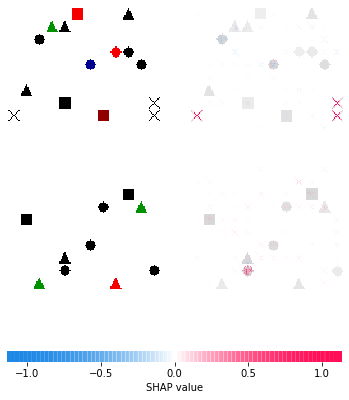

In [12]:
batch_Size = 2000

test_data = ImageFolder(root = os.path.join(root_dir, 'test'), transform = transforms)
dataloader = DataLoader(test_data, batch_size = batch_Size, shuffle = False, num_workers = 0)
train_loader = iter(dataloader)
X,Y = next(train_loader)


batch_Size = 2
dataloader = DataLoader(images, batch_size = batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
x,y = next(train_loader)



to_explain = x


e = shap.GradientExplainer(net, X)

shap_values,indexes = e.shap_values(to_explain, ranked_outputs=1, nsamples=200)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

to_explain = to_explain.numpy()

to_explain = np.swapaxes(to_explain,1,2)
to_explain = np.swapaxes(to_explain,2,3)

shap.image_plot(shap_values, to_explain)